In [2]:

import numpy as np
import astropy.units as u
from astropy.io import fits
import copy

import poppy

import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3

wavelength = 633*u.nm
fsm_pupil_diam = 4*u.mm
fl = 200*u.mm
relay_fl = 200*u.mm
zwfs_pupil_diam =  fsm_pupil_diam * relay_fl/fl
zwfs_pxscl = 5*3.45*u.um
fnum = (fl/fsm_pupil_diam).decompose().value
as_per_lamD = ((wavelength/fsm_pupil_diam).decompose() * u.radian).to(u.arcsec)
print(zwfs_pupil_diam)
print(fnum)
print(as_per_lamD)

npix = int((zwfs_pupil_diam/zwfs_pxscl).decompose().value) + 1
print(npix)


4.0 mm
50.0
32.64140558860301 arcsec
232


Oversampling > 2x suggested for reliable results in Fresnel propagation.


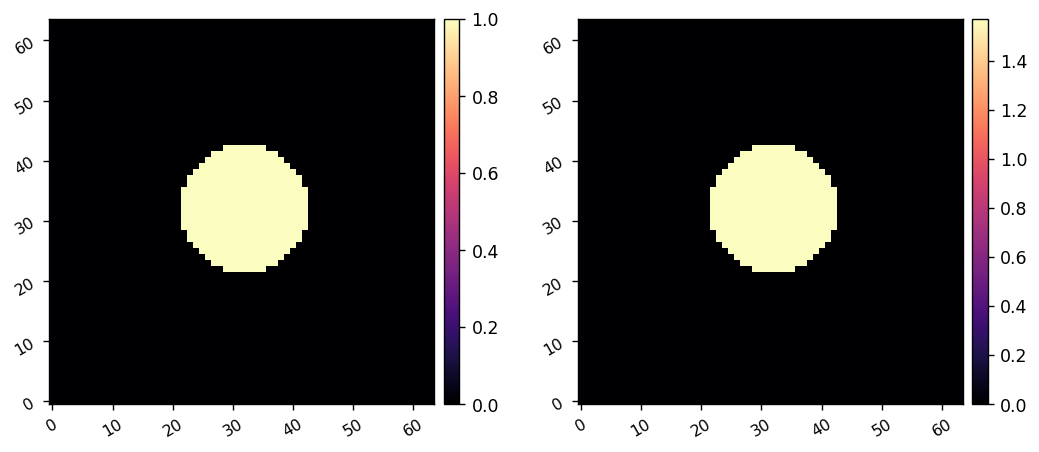

In [48]:
# npix = 256
oversample = 20
N = int(npix*oversample)

pwf = poppy.FresnelWavefront(beam_radius=fsm_pupil_diam/2, npix=npix, oversample=1) # pupil wavefront
ap = poppy.CircularAperture(radius=fsm_pupil_diam/2).get_transmission(pwf)
mask = ap.astype(bool)
z_modes = poppy.zernike.arbitrary_basis(ap, nterms=20, outside=0)[1:]
tt_modes = z_modes[:2] 
z_modes = z_modes[2:]
Nz = len(z_modes)

zwfs_pixelscale_lamD = 1/oversample
y,x = (xp.indices((N, N)) - N//2)*zwfs_pixelscale_lamD
r = xp.sqrt(x**2 + y**2)
M = r<1.06/2
zwfs_mask = xp.exp(1j * xp.pi/2 * M)
imshow2(M, xp.angle(zwfs_mask), npix=64)

def fft(arr):
    return xp.fft.ifftshift(xp.fft.fft2(xp.fft.fftshift(arr)))

def ifft(arr):
    return xp.fft.fftshift(xp.fft.ifft2(xp.fft.ifftshift(arr)))

def snap_zwfs(pupil, use_zwfs=True):

    fpwf = fft(utils.pad_or_crop(pupil, N))
    fpwf *= zwfs_mask if use_zwfs else 1
    ppwf = ifft(fpwf)
    ppim = xp.abs(ppwf)**2
    return utils.pad_or_crop(ppim, npix)

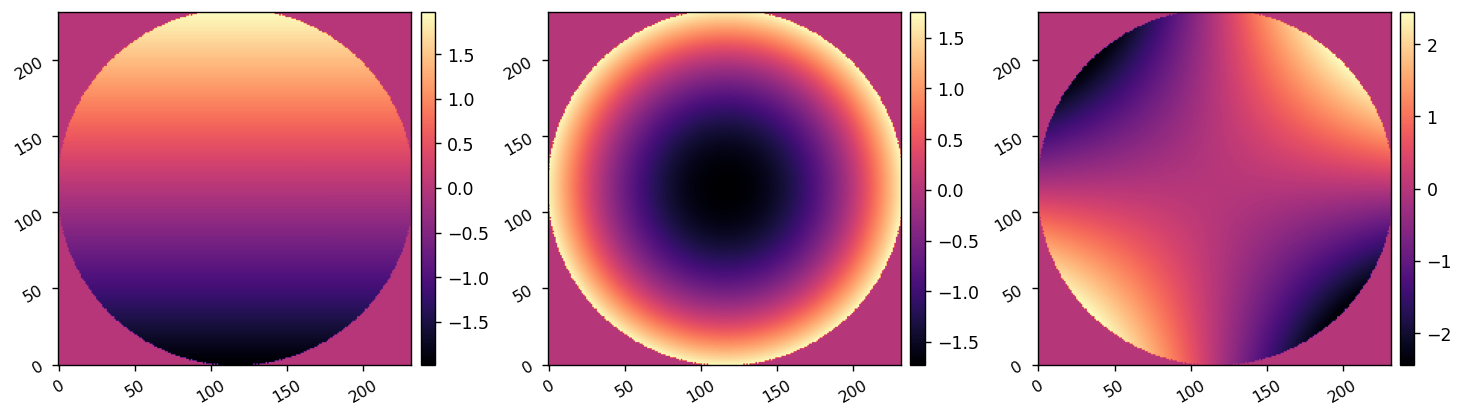

In [49]:
imshow3(tt_modes[1], z_modes[0], z_modes[1], npix=npix)

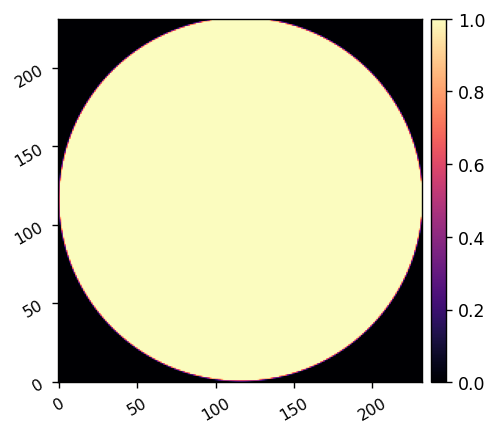

In [51]:
P = snap_zwfs(ap, use_zwfs=False)
imshow1(P)

In [73]:
b = utils.pad_or_crop( ifft(M * fft( utils.pad_or_crop(ap, N))), npix)
b.shape, P.shape

((232, 232), (232, 232))

2.520443768889441e-09


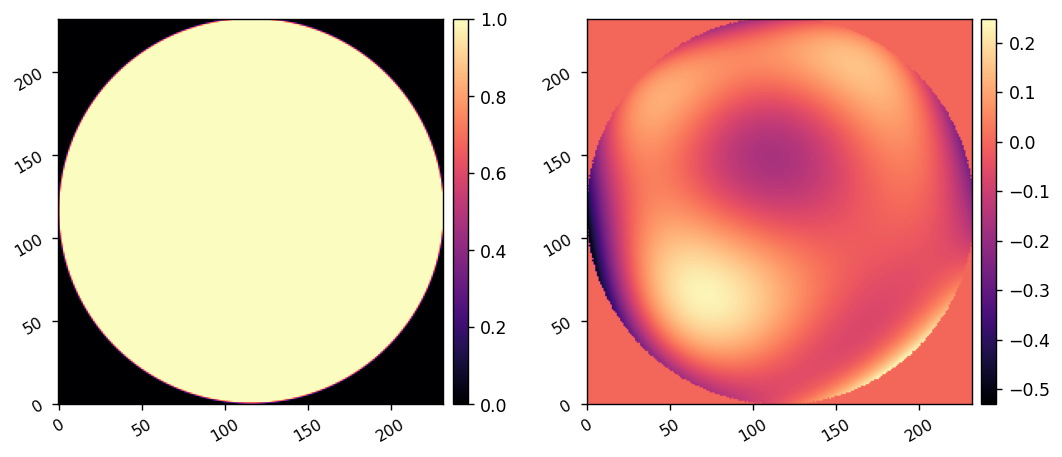

In [119]:
xp.random.seed(123)
z_coeff = 3e-9 * xp.random.randn(Nz)
z_rms = xp.sqrt(xp.mean(xp.square(z_coeff)))
print(z_rms)
opd = xp.sum(z_coeff[:, None, None] * z_modes, axis=0)
pupil = ap * xp.exp(1j * 2*xp.pi / wavelength.to_value(u.m) * opd )
imshow2(xp.abs(pupil), xp.angle(pupil))

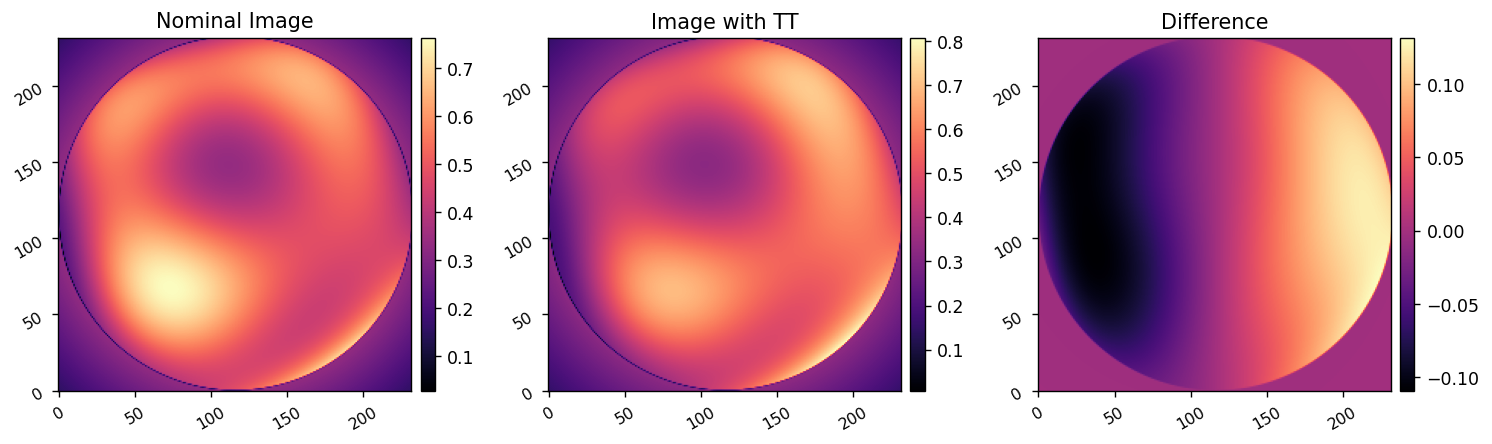

In [115]:
Ic0 = snap_zwfs(pupil)

tt = 10e-9 * tt_modes[0]
tt_phasor = xp.exp(1j * 2*xp.pi / wavelength.to_value(u.m) * tt )
Ic_tt = snap_zwfs(pupil*tt_phasor)
diff = Ic_tt - Ic0
imshow3(Ic0, Ic_tt, diff, 'Nominal Image', 'Image with TT', 'Difference',)

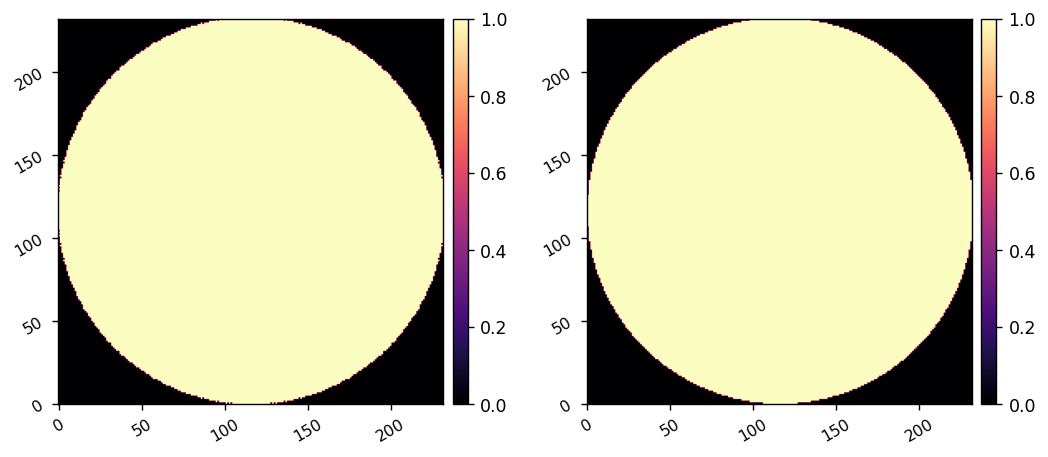

9.674673052986176e-09


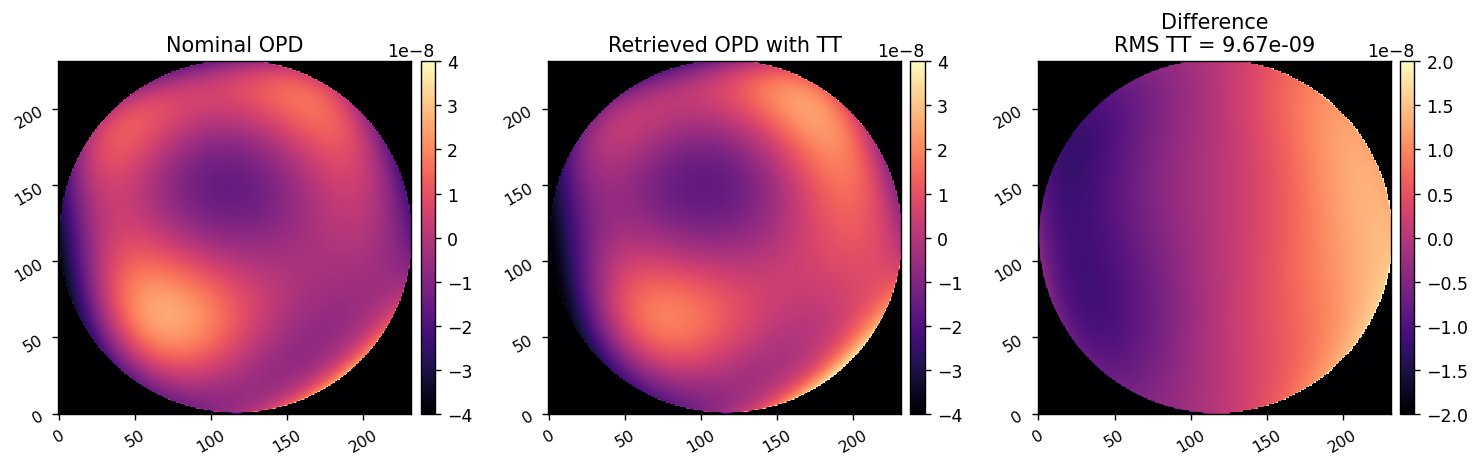

In [118]:
phi0 = ( Ic0 - P**2 - 2*b**2 + 2*P*b ) / (2*P*b)
opd0 = phi0.real * wavelength.to_value(u.m)/(2*np.pi)

phi_tt = ( Ic_tt - P**2 - 2*b**2 + 2*P*b ) / (2*P*b)
opd_tt = phi_tt.real * wavelength.to_value(u.m)/(2*np.pi)

opd_diff = opd_tt - opd0
data_mask = (xp.abs(opd_tt) < 200e-8)
imshow2(mask, data_mask, npix=npix)

rms = xp.sqrt(xp.mean(xp.square(opd_diff[data_mask])))
print(rms)

vmax_opd = 40e-9
vmax_tt = 20e-9
imshow3(opd0, opd_tt, opd_diff,
        'Nominal OPD', 'Retrieved OPD with TT', f'Difference\nRMS TT = {rms:.2e}',
        npix=npix, 
        vmin1=-vmax_opd, vmax1=vmax_opd, 
        vmin2=-vmax_opd, vmax2=vmax_opd, 
        vmin3=-vmax_tt, vmax3=vmax_tt,
        )